In [9]:
import pandas as pd
import numpy as np

In [10]:
customers = pd.read_csv(r"C:\Users\AFAQE\Desktop\Me\customers.csv")
geolocation = pd.read_csv(r"C:\Users\AFAQE\Desktop\Me\geolocation.csv")
order_items = pd.read_csv(r"C:\Users\AFAQE\Desktop\Me\order_items.csv")
orders = pd.read_csv(r"C:\Users\AFAQE\Desktop\Me\orders.csv")
payments = pd.read_csv(r"C:\Users\AFAQE\Desktop\Me\payments.csv")
products = pd.read_csv(r"C:\Users\AFAQE\Desktop\Me\products.csv")
sellers = pd.read_csv(r"C:\Users\AFAQE\Desktop\Me\sellers.csv")

In [11]:
order_items.head

<bound method NDFrame.head of                                 order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abb

In [19]:
orders_small = orders[[
    'order_id',
    'order_status',
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]]

## Filter Orders table schedule by delivered orders

In [32]:
delivered = orders[orders["order_status"]=="delivered"]

In [33]:
delivered.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

## Merge the customer table with delivered table

In [34]:
delivered_customers = delivered.merge(customers,on="customer_id",how="left")

In [17]:
delivered_orders.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'order_status',
       'order_purchase_timestamp', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [42]:
orders_delivered = orders[orders["order_status"]=="delivered"]

## Merge the orders_delivered table with order_items table

In [38]:
orders_items_delivered = orders_delivered.merge(order_items, on='order_id', how='inner')

## Adding new column to orders_items_delivered table 

In [41]:
orders_items_delivered["total_value"]=(orders_items_delivered["price"] + orders_items_delivered["freight_value"])

In [46]:
order_items_customers = orders_items_delivered.merge(customers,on="customer_id",how="left")

## Aggregating total pay for every customer

In [51]:
customer_spend = (order_items_customers.groupby('customer_unique_id')['total_value'].sum().reset_index()
    .sort_values(by='total_value', ascending=False))

## Top 1o customers

In [53]:
customer_spend.head(10)

,customer_unique_id,total_value
3724,0a0a92112bd4c708ca5fde585afaa872,13664.08
79636,da122df9eeddfedc1dc1f5349a1a690c,7571.63
43168,763c8b1c9c68a0229c42c9fc6f662b93,7274.88
80463,dc4802a71eae9be1dd28f5d788ceb526,6929.31
25436,459bef486812aa25204be022145caa62,6922.21
93081,ff4159b92c40ebe40454e3e6a7c35ed6,6726.66
23411,4007669dec559734d6f53e029e360987,6081.54
87148,eebb5dda148d3893cdaf5b5ca3040ccb,4764.34
26640,48e1ac109decbb87765a3eade6854098,4681.78
73127,c8460e4251689ba205045f3ea17884a1,4655.88


In [54]:
delivered = orders[orders["order_status"]=="delivered"].copy()

## Calculation the actual order delivery time 

In [61]:
delivered["order_delivered_customer_date"] = pd.to_datetime(
    delivered["order_delivered_customer_date"],
    errors="coerce"
)

delivered["order_purchase_timestamp"] = pd.to_datetime(
    delivered["order_purchase_timestamp"],
    errors="coerce"
)


In [62]:
delivered["delivery_time_days"] =(delivered["order_delivered_customer_date"] - delivered["order_purchase_timestamp"]).dt.days

In [66]:
delivered["delivery_time_days"]

0         8.0
1        13.0
2         9.0
3        13.0
4         2.0
         ... 
99436     8.0
99437    22.0
99438    24.0
99439    17.0
99440     7.0
Name: delivery_time_days, Length: 96478, dtype: float64

## Is the order delayed in delivery

In [68]:
delivered["order_estimated_delivery_date"] = pd.to_datetime(
    delivered["order_estimated_delivery_date"],
    errors="coerce"
)

In [163]:
delivered["delay_day"] = delivered["order_delivered_customer_date"] - delivered["order_estimated_delivery_date"]
delivered["delay_day"]

0        -8 days +21:25:00
1        -6 days +15:27:00
2       -18 days +18:06:00
3       -13 days +00:28:00
4       -10 days +18:17:00
               ...        
99436   -11 days +15:08:00
99437    -2 days +17:37:00
99438    -6 days +11:24:00
99439   -21 days +23:32:00
99440   -18 days +13:08:00
Name: delay_day, Length: 96478, dtype: timedelta64[ns]

In [164]:
delivered['delay_day'] = delivered['delay_day'].dt.days

In [166]:
delivered["delivery_status"] = delivered["delay_day"].apply(
    lambda x: "Late" if x > 0 else "On Time / Early")

In [76]:
delivered['delivery_status']

0        On Time / Early
1        On Time / Early
2        On Time / Early
3        On Time / Early
4        On Time / Early
              ...       
99436    On Time / Early
99437    On Time / Early
99438    On Time / Early
99439    On Time / Early
99440    On Time / Early
Name: delivery_status, Length: 96478, dtype: object

In [78]:
delivered["delivery_status"].value_counts(normalize=True)*100

delivery_status
On Time / Early    93.227472
Late                6.772528
Name: proportion, dtype: float64

In [79]:
delivered_items = delivered.merge(order_items,on="order_id",how="left")

In [107]:
delivered_items[["order_id","seller_id","delay_day"]].head()

,order_id,seller_id,delay_day
0,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,66922902710d126a0e7d26b0e3805106,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2c9e548be18521d1c43cde1c582c6de8,-10.0


In [108]:
delivered_items["late_delay"] = delivered_items["delay_day"].apply(lambda x:x if x > 0 else 0)

In [109]:
seller_delay = (delivered_items.groupby('seller_id').agg(avg_late_delay=('late_delay', 'mean'), orders_count=('order_id', 'nunique')).reset_index())
seller_delay = seller_delay[seller_delay["orders_count"]>=20]

## Worest 10 sellers

In [111]:
seller_delay.sort_values(by="avg_late_delay",ascending=False).head(5)

,seller_id,avg_late_delay,orders_count
478,2a1348e9addc1af5aaa619b1a3679d6b,11.549020,48
57,054694fa03fe82cec4b7551487331d74,10.000000,20
1000,54965bbe3e4f07ae045b90b0b8541f52,8.765432,73
2365,cac4c8e7b1ca6252d8f20b2fc1a2e4af,5.951220,74
2792,f08c008c8a8d31417763738a1788a2a8,5.666667,20


In [113]:
delivered_items['is_late'] = delivered_items['delay_day'] > 0

seller_metrics = (
    delivered_items
    .groupby('seller_id')
    .agg(
        avg_late_delay=('late_delay', 'mean'),
        late_orders_ratio=('is_late', 'mean'),
        orders_count=('order_id', 'nunique')
    )
    .reset_index()
)

In [114]:
seller_metrics

,seller_id,avg_late_delay,late_orders_ratio,orders_count
0,0015a82c2db000af6aaaf3ae2ecb0532,0.000000,0.000000,3
1,001cca7ae9ae17fb1caed9dfb1094831,0.619658,0.051282,195
2,002100f778ceb8431b7a1020ff7ab48f,1.240741,0.166667,50
3,003554e2dce176b5555353e4f3555ac8,0.000000,0.000000,1
4,004c9cd9d87a3c30c522c48c4fc07416,0.648810,0.059524,156
...,...,...,...,...
2965,ffc470761de7d0232558ba5e786e57b7,0.533333,0.066667,27
2966,ffdd9f82b9a447f6f8d4b91554cc7dd3,0.000000,0.000000,18
2967,ffeee66ac5d5a62fe688b9d26f83f534,1.785714,0.142857,14
2968,fffd5413c0700ac820c7069d66d98c89,0.672414,0.120690,57


In [117]:
order_weight = (
    order_items
    .merge(products, on='product_id')
    .groupby('order_id')['product_weight_g']
    .sum()
    .reset_index()
)


In [122]:
order_weight

,order_id,product_weight_g
0,00010242fe8c5a6d1ba2dd792cb16214,650.0
1,00018f77f2f0320c557190d7a144bdd3,30000.0
2,000229ec398224ef6ca0657da4fc703e,3050.0
3,00024acbcdf0a6daa1e931b038114c75,200.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3750.0
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,10150.0
98662,fffcd46ef2263f404302a634eb57f7eb,8950.0
98663,fffce4705a9662cd70adb13d4a31832d,967.0
98664,fffe18544ffabc95dfada21779c9644f,100.0


In [146]:
order_weight = (
    order_items
    .merge(products, on='product_id')
    .groupby('order_id')['product_weight_g']
    .sum()
    .reset_index()
)

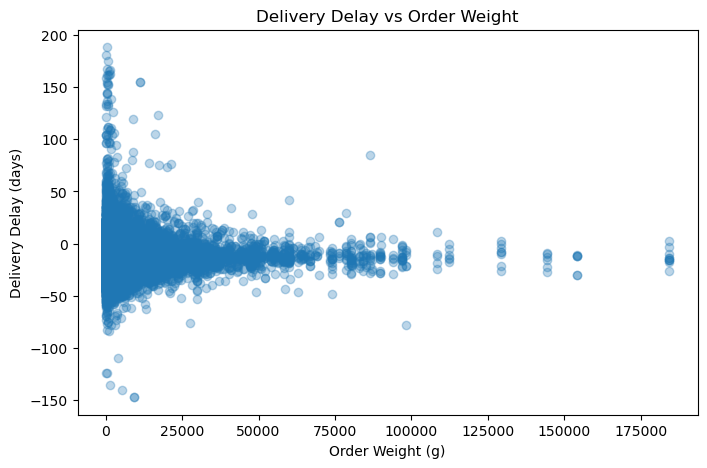

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(delivered_orders['product_weight_g'], delivered_orders['delay_day'], alpha=0.3)
plt.xlabel('Order Weight (g)')
plt.ylabel('Delivery Delay (days)')
plt.title('Delivery Delay vs Order Weight')
plt.show()

In [150]:
delivered_orders['weight_bucket'] = pd.qcut(delivered_orders['product_weight_g'], 4) 

avg_delay_per_bucket = delivered_orders.groupby('weight_bucket')['delay_day'].mean().reset_index()
print(avg_delay_per_bucket)

        weight_bucket  delay_day
0     (-0.001, 350.0] -12.052551
1      (350.0, 850.0] -12.051253
2     (850.0, 2500.0] -12.037904
3  (2500.0, 184400.0] -11.973496


C:\Users\AFAQE\AppData\Local\Temp\ipykernel_6316\661810013.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delay_per_bucket = delivered_orders.groupby('weight_bucket')['delay_day'].mean().reset_index()


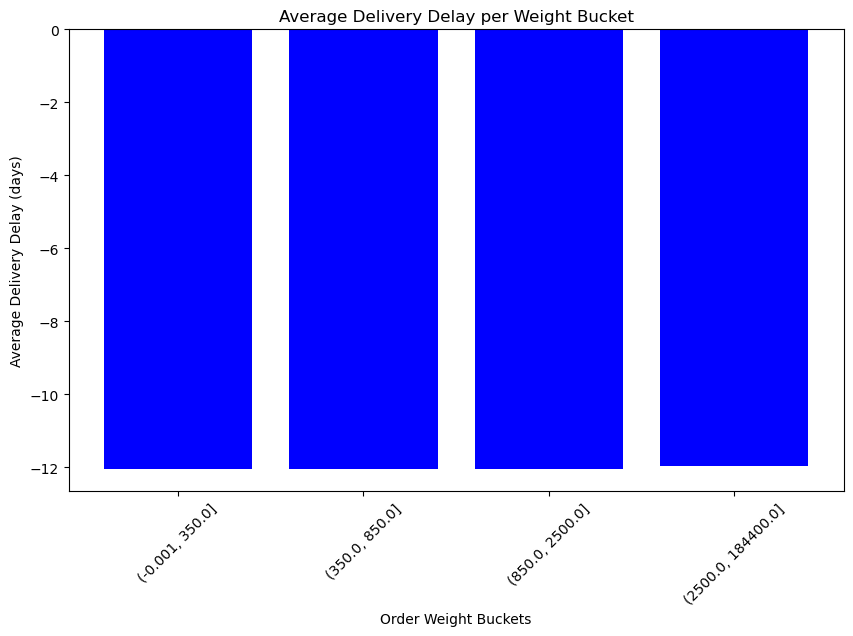

In [157]:
plt.figure(figsize=(10,6))
plt.bar(
    avg_delay_per_bucket['weight_bucket'].astype(str),
    avg_delay_per_bucket['delay_day'],
    color='blue'
)
plt.xlabel('Order Weight Buckets')
plt.ylabel('Average Delivery Delay (days)')
plt.title('Average Delivery Delay per Weight Bucket')
plt.xticks(rotation=45)
plt.show()